# Predicting Coca crops

We will do so by training neural networks with a couple of datasets configuration and with two neural networks architecutre. First with a simple neural network, that will show that even with this non-image specialized architectures good results can be obtained. And second using a more complex convolunation neural network architecture. 



## Preparations
### Import libraries

In [ ]:
# import basic libraries
import numpy as np
import pandas as pd
import os
!pip install rasterio
import rasterio
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import random_split
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torch.optim.lr_scheduler
from matplotlib import image
from matplotlib import pyplot

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#sns.set(style="darkgrid")
#palette = sns.set_palette('rocket')

from google.colab import drive
drive.mount('/content/drive')

#data_dir = '/Users/juanpicciotti/BSE/2term/Spatial/project/data/'

     |████████████████████████████████| 19.3 MB 1.2 MB/s 
Mounted at /content/drive


We collected the following data:

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Classroom/21DM008 Analysis of Spatial Data and Images 21-22 DSDM T2/project/data_final.csv")
df = df.drop(["Unnamed: 0"], axis = 1)
df

,geometry,coca
0,POINT (-64.3702 -17.4199),1
1,POINT (-71.7355 -3.875),1
2,POINT (-73.963 -12.4977),1
3,POINT (-68.969 -14.1864),1
4,POINT (-64.6217 -17.0965),1
...,...,...
1995,POINT (-71.13674333547164 -10.751785082593383),0
1996,POINT (-77.17483556176035 3.440779179280163),0
1997,POINT (-72.61253306179833 -3.1637703990291577),0
1998,POINT (-67.98936148404121 1.9200157113279914),0


The first 1000 rows offer the coordinates of places in Colombia which were raided by the police due to harboring coca plantations.

The other 1000 rows are points generated at random within the limits of Colombia, Peru and Bolivia that are not associated with coca plantations.

The way we collected this was the following:

This resulted in a dataset of 2000 satellite images in TIFF format.

## TIFF Format

JPEGs look like this:

TIFFs on the other hand are a bit more complicated to handle:

In [ ]:
from osgeo import gdal
tiff = gdal.Open('/content/drive/MyDrive/spatial_final_r/image_10.tif')
print(tiff.RasterCount)

3


To get the bands we use GDAL’s GetRasterBand function. Note the indexing for bands starts from 1 and not 0: 

In [ ]:
# since there are 3 bands
# we store in 3 different variables
band1 = tiff.GetRasterBand(1) # Red channel
band2 = tiff.GetRasterBand(2) # Green channel
band3 = tiff.GetRasterBand(3) # Blue channel

And then we transform to Numpy arrays with GDAL's ReadAsArray() method: 

In [ ]:
b1 = band1.ReadAsArray()
b2 = band2.ReadAsArray()
b3 = band3.ReadAsArray()
b1

array([[ -2.98860691,  -4.80098069,  -5.23882278, ...,  -7.80864677,
         -8.47846105,  -5.80729964],
       [ -6.5543139 ,  -6.9172933 ,  -6.52723512, ...,  -7.51057966,
         -8.5605612 ,  -6.20759686],
       [ -5.25896751,  -5.16840799,  -6.58519268, ...,  -9.12617786,
         -8.08921796,  -6.51803967],
       ...,
       [ -8.10700956,  -7.55130327,  -8.77899426, ...,  -6.38452382,
         -9.3056942 ,  -7.83030336],
       [ -4.2344241 ,  -4.04889322,  -9.00246938, ...,  -6.29548635,
         -9.57622473,  -7.57353198],
       [ -4.10725624,  -4.58463691, -11.06364384, ..., -12.60582355,
        -11.80077209, -10.68750228]])

To plot the three arrays we will stack them in sequence. 

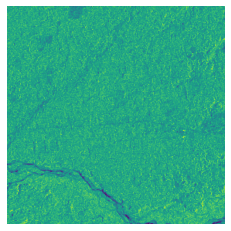

In [ ]:
img = np.dstack((b1, b2, b3))
f = plt.figure()
#plt.imshow(img) 
plt.imshow(b2)
plt.axis('off')
#plt.savefig('Tiff.png')
plt.show()

# why is it black? if you print any of the bands, you get a colored plot

Transform the tiff files into png :

USING ONLY ONE BAND 

In [ ]:
# list the file names in folder "0" and "1":

mypath = "/content/drive/My Drive/Spatial/Project/data/0"
from os import listdir
from os.path import isfile, join
file_names0 = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])
print("length of list: "+ str(len(file_names0)))
print(file_names0[0])

mypath = "/content/drive/My Drive/Spatial/Project/data/1"
from os import listdir
from os.path import isfile, join
file_names1 = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])
print("length of list: "+ str(len(file_names1)))
file_names1

20


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


40
60
80
100


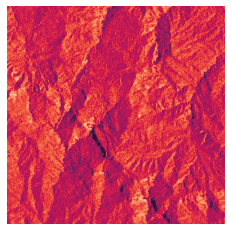

In [ ]:
n = 200
count = 0
for file in file_names0[n:n+100]:
  count = count + 1
  if count%20 == 0: print(count)
  tiff = gdal.Open('/content/drive/My Drive/Spatial/Project/data/0/' + file)

  b1 = tiff.GetRasterBand(1).ReadAsArray() # Red channel
  #b2 = tiff.GetRasterBand(2).ReadAsArray() # Green channel
  #b3 = tiff.GetRasterBand(3).ReadAsArray() # Blue channel
  #img = np.dstack((b1, b2, b3))
  #f = plt.figure()
  #plt.imshow(img) 
  plt.axis('off')
  plt.imshow(b1)
  plt.savefig('/content/drive/My Drive/Spatial/Project/data/png/0/'+ file[:-3] + 'png', bbox_inches='tight', pad_inches=0)

20


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


40
60
80
100


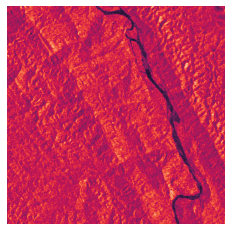

In [ ]:
n = 200
count = 0
for file in file_names1[n:n+100]:
  count = count + 1
  if count%20 == 0: print(count)
  tiff = gdal.Open('/content/drive/My Drive/Spatial/Project/data/1/' + file)

  b1 = tiff.GetRasterBand(1).ReadAsArray() # Red channel
  #b2 = tiff.GetRasterBand(2).ReadAsArray() # Green channel
  #b3 = tiff.GetRasterBand(3).ReadAsArray() # Blue channel
  #img = np.dstack((b1, b2, b3))
  #f = plt.figure()
  #plt.imshow(img) 
  plt.axis('off')
  plt.imshow(b1)

  plt.savefig('/content/drive/My Drive/Spatial/Project/data/png/1/'+ file[:-3] + 'png', bbox_inches='tight', pad_inches=0)

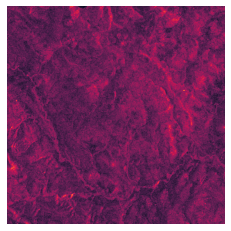

In [ ]:
n = 0
count = 0
for file in file_names0[n:n+1]:
  count = count + 1
  if count%20 == 0: print(count)
  tiff = gdal.Open('/content/drive/My Drive/Spatial/Project/data/0/' + file)

  b1 = tiff.GetRasterBand(1).ReadAsArray() # Red channel
  b2 = tiff.GetRasterBand(2).ReadAsArray() # Green channel
  b3 = tiff.GetRasterBand(3).ReadAsArray() # Blue channel
  #img = np.dstack((b1, b2, b3))
  #f = plt.figure()
  #plt.imshow(img) 
  plt.axis('off')
  plt.imshow(b1)
  plt.savefig('/content/drive/My Drive/Spatial/Project/data/png/A0/'+ file[:-3] + 'png', bbox_inches='tight', pad_inches=0)
  plt.imshow(b2)
  plt.savefig('/content/drive/My Drive/Spatial/Project/data/png/B0/'+ file[:-3] + 'png', bbox_inches='tight', pad_inches=0)
  plt.imshow(b3)
  plt.savefig('/content/drive/My Drive/Spatial/Project/data/png/C0/'+ file[:-3] + 'png', bbox_inches='tight', pad_inches=0)


float32
(217, 217, 4)


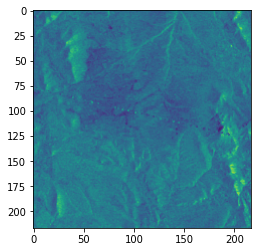

In [ ]:
jpeg = image.imread('/content/drive/MyDrive/Classroom/21DM008 Analysis of Spatial Data and Images 21-22 DSDM T2/project/Project/data/png/0/image_1099.png')

print(jpeg.dtype)
print(jpeg.shape)
# display the array of pixels as an image
pyplot.imshow(jpeg)
pyplot.show()



##Try it for all 3 bands:

In [ ]:
# list the file names in folder "0" and "1":

mypath = "/content/drive/MyDrive/Classroom/21DM008 Analysis of Spatial Data and Images 21-22 DSDM T2/project/Project/data/0"
from os import listdir
from os.path import isfile, join
file_names0 = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print("length of list: "+ str(len(file_names0)))
print(file_names0[0])

mypath = "/content/drive/MyDrive/Classroom/21DM008 Analysis of Spatial Data and Images 21-22 DSDM T2/project/Project/data/1"
from os import listdir
from os.path import isfile, join
file_names1 = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print("length of list: "+ str(len(file_names1)))
file_names1[0]

length of list: 1000
image_1336.tif
length of list: 1000


'image_1.tif'

In [ ]:
for file in file_names0:
  tiff = gdal.Open('/content/drive/My Drive/Spatial/Project/data/0/' + file)

  b1 = tiff.GetRasterBand(1).ReadAsArray() # Red channel
  b2 = tiff.GetRasterBand(2).ReadAsArray() # Green channel
  b3 = tiff.GetRasterBand(3).ReadAsArray() # Blue channel
  img = np.dstack((b1, b2, b3))
  f = plt.figure()
  plt.imshow(img) 
  plt.savefig('/content/drive/My Drive/Spatial/Project/data/png/0'+ file[:-3] + 'png')

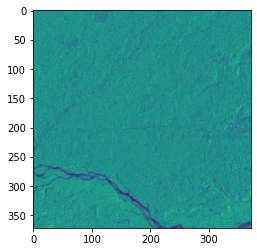

In [ ]:
tiff = gdal.Open('/content/drive/My Drive/Spatial/Project/data/1/image_10.tif')

b1 = tiff.GetRasterBand(1).ReadAsArray() # Red channel
b2 = tiff.GetRasterBand(2).ReadAsArray() # Green channel
b3 = tiff.GetRasterBand(3).ReadAsArray() # Blue channel
img = np.dstack((b1, b2, b3))
f = plt.figure()
plt.imshow(b3)
plt.savefig('/content/drive/My Drive/Spatial/Project/data/png/Tiff1.png')

# Neural Networks:

Training on GPUs is way faster:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Auxiliary functions
In this part we define the classes and functions that will be used through the notebook.

First we define a couple of classes to convert our images in to the dataset/dataloader format that is used by pytorch

Second, we define the train and test function that wil be used in both our neural networks configurations

In [ ]:
# Auxiliary functions
# Create custom dataloader class object for dataset 1 (28px)
class dataset(torch.utils.data.Dataset):

  def __init__(self, src_file, num_rows=None):
    y_tmp = src_file['label']
    y_tmp = y_tmp.values
    x_tmp = src_file.drop('label', axis=1)
    x_tmp = x_tmp.values
    self.x_data = torch.tensor(x_tmp, dtype=torch.float32).to(device)
    self.y_data = torch.tensor(y_tmp, dtype=torch.long).to(device)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = self.x_data[idx, 0:784]
    label = self.y_data[idx]
    return image, label

# Custom dataloader class object for dataset 2 (64 px)
class coca372_dataset(torch.utils.data.Dataset):

  def __init__(self, data, label, num_rows=None):
    y_tmp = label
    x_tmp = data
    self.x_data = torch.tensor(x_tmp, dtype=torch.float32).to(device)
    self.y_data = torch.tensor(y_tmp, dtype=torch.long).to(device)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = self.x_data[idx, 0:12288]
    label = self.y_data[idx]
    return image, label

# train function
def train(model, optimizer, data_loader):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, channels, img_size, img_size)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        train_loss += F.cross_entropy(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy, train_loss

# test function
def test(model, data_loader): 
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        data = data.view(-1, channels,img_size,img_size)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1]                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy, test_loss

def freeze_model(model):
    for parameter in model.parameters():
        parameter.requires_grad = False

### Load data

We will work with the following dataset:

- 2K 217x217 with 3 channels

We will use the ImageLoader library from pytorch, we will additionally resize and normalize the images to allow a faster processing. We will rescale from 372px to 186px, transform the image data to tensor and normalize for the data to be always between -1 and 1, this will allows us to iterate through the dataset with our specified batch size and use the native coding of our x and y variables

In [ ]:
# define batch size and load dataset
batch_size = 16

# define labels map
alph = {0: "Coca", 1: "No_coca"}

# load dataset from image folder
data_dir = '/content/drive/MyDrive/Classroom/21DM008 Analysis of Spatial Data and Images 21-22 DSDM T2/project/Project/data/png/Band2'

# load classes
classes = ["0", "1"]

resize = (25, 25)

# set the transform steps for all the images
transform = tt.Compose(
    [
        tt.Resize(resize),
        tt.ToTensor(),
        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalized the images in the range -1, 1
    ]
)

# read the images into a pytorch dataset and apply processing
dataset_resized = ImageFolder(data_dir, transform)

# define the train and test datasets
test_size = int(round(len(dataset_resized)*0.1,0))
train_size = len(dataset_resized) - test_size
train_data, test_data = random_split(dataset_resized, [train_size, test_size])

# set the pytoarch loaders
train_data_ldr = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data_ldr = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=True)

In [ ]:
# define batch size and load dataset
batch_size = 16

# define labels map
alph = {0: "Coca", 1: "No_coca"}

# load dataset from image folder
data_dir = '/content/drive/MyDrive/Classroom/21DM008 Analysis of Spatial Data and Images 21-22 DSDM T2/project/Project/data/png/temp_test'

# load classes
classes = ["0", "1"]

resize = (217, 217)

# set the transform steps for all the images
transform = tt.Compose(
    [
        tt.Resize(resize),
        tt.ToTensor(),
        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalized the images in the range -1, 1
    ]
)

# read the images into a pytorch dataset and apply processing
dataset_resized = ImageFolder(data_dir, transform)

# define the train and test datasets
test_size = int(round(len(dataset_resized)*0.1,0))
train_size = len(dataset_resized) - test_size
train_data, test_data = random_split(dataset_resized, [train_size, test_size])

# set the pytoarch loaders
train_data_ldr_2 = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data_ldr_2 = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=True)

In [ ]:
for i in train_data_ldr_2:
  #print(i[0].shape)
  c = torch.stack((i[0],i[0]),axis=2) 
  break

In [ ]:
c.shape

torch.Size([16, 3, 2, 217, 217])

In [ ]:
type(train_data_ldr)

torch.utils.data.dataloader.DataLoader

In [ ]:
len(dataset_resized[0][0][0][0])


217

This is a preview of 64x64 pixels images dataset (converted to 32x32)

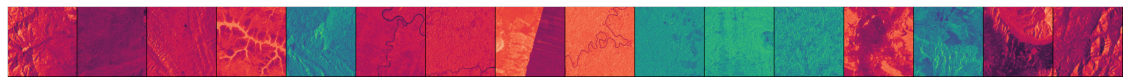

In [ ]:
# plot sample images for dataset 2
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 12))
        ax.set_xticks([]); ax.set_yticks([])
        images = (images * 0.5) + 0.5 # denormalize the dataset

        ax.imshow(make_grid(images, nrow=20).permute(1,2,0))
        break

show_batch(train_data_ldr)

In [1]:
# get class frequency
labels_list = list()
for _, labels in train_data_ldr:
    labels_list= np.concatenate((labels_list,labels))

# replace class numbers with text mask
labels = [classes[int(x)] for x in labels_list]
labels.sort()

# plot class frequency
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Class distribution for 32x32 pixels image dataset', size=20)
plot = sns.histplot(data=labels, alpha=0.7, stat='count')
#plot.bar_label(plot.containers[0], size=9)
plt.setp(plot.get_xticklabels(), rotation=90);

## Simple network case

### Parameters setup
For the simple network scenario, we will apply the following parameters:

<b>Hidden units</b>
While using the 28x28 dataset, since we only have 1 channel, the depth of the 512 hidden units will help us improve the prediction power of the algorithm, previous tests with lower hidden units show less predictive power.

<b>Learning rate</b>
The learning rate parameter will be set in a fixed maner to 0.0001. The training is equipped with the capability to use decreasing learning rate using pytorch exponential learning rate scheduler, but the parameter that sets the decreasing rate (gamma) has been set to 1, so the learning rate will be fixed. In several try outs decreasing the learning rate did not improve our performance.

https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html

<b>Batch size</b>
The batch size has been previously setup at the moment the dataloaders were created, but it is important to mention we choose a batch size = 100, this provides good training stability and generalization performance. Smaller batch size have been tested with no better results.

https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [ ]:
# Set parameters
channels = 3                            # channels for the images
img_size = resize[0]                       # image height=width
in_size = img_size*img_size*channels    # initial size fed to linear layers
out_size = 2                            # number of classes, also final output of the network
epochs = 10  
#epochs = 100                            # number of epochs to run, kept to 10 to keep exercise computationally feasible
#learning_rate = 0.0001                # learning rate
learning_rate = 0.01                # learning rate
gamma = 1                               # rate of learning rate decrease per epoch, if gamma=1 learning rate is fixed
n_hidden = 512                          # number of hidden units

### Define network architecture
The simple network architecture scenario will use only 3 fully connected or linear layers together with their corresponding non-linear activation functions (ReLU) and a final softmax layer. 

The layer size of the architecture would be:

Initial size = 3x217x217

- FC1 output = 512  

- FC2 output = 120

- FC3 output = 2

<b>Fully connected / linear layer</b>

<img src="simple_network.png">

In [ ]:
# create network arquitecture
# simple NN architecture
class simple(nn.Module):
    def __init__(self, in_size, n_hidden, out_size):
        super(simple, self).__init__()
        self.in_size = in_size
        self.n_hidden = n_hidden
        self.out_size = out_size
        self.network = nn.Sequential(
            nn.Linear(self.in_size, self.n_hidden), 
            nn.ReLU(), 
            nn.Linear(self.n_hidden, 256),
            nn.ReLU(), 
            nn.Dropout2d(0.5),
            nn.Linear(256, out_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.in_size)
        return self.network(x)

### Instantiate and train/test network model

<b>Optimization algorithm</b>
We will be using the SGD optimization algorithm, which is a simple yet very efficient approach to fitting linear classifiers and it is known to generalize better. 

https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008#:~:text=One%20interesting%20and%20dominant%20argument,results%20in%20improved%20final%20performance.

Below we can see a summary of the created model and the output shapes and parameters at each linear layer

In [2]:
# instantiate model, setup optimizer, print network architecture summary
model_fnn = simple(in_size, n_hidden, out_size)
model_fnn.to(device)
optimizer = torch.optim.SGD(model_fnn.parameters(),lr=learning_rate)

summary(model_fnn, input_size = (channels,img_size,img_size), batch_size = -1)

So we are now ready to start our training based on the parameters and architecture described earlier

In [ ]:
# run train and test tasks and store results
results = pd.DataFrame()

for epoch in range(0, epochs):
    temp = pd.DataFrame()
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    print('Epoch = '+str(epoch)+' Learning Rate = ',optimizer.param_groups[0]["lr"])
    
    train_accuracy, train_loss = train(model_fnn, optimizer, train_data_ldr)
    print('Train set: Average loss: {:.4f}, Accuracy:({:.0f}%)'.format(train_loss, train_accuracy))
    test_accuracy, test_loss = test(model_fnn, test_data_ldr)
    print('Test set: Average loss: {:.4f}, Accuracy:({:.0f}%)'.format(test_loss, test_accuracy))
    
    temp['nn'], temp['phase'], temp['epoch'], temp['accuracy'], temp['loss'] = zip(['simple', 'train', epoch, train_accuracy, train_loss])
    results = results.append(temp)
    temp['nn'], temp['phase'], temp['epoch'],  temp['accuracy'], temp['loss'] = zip(['simple', 'test', epoch, test_accuracy, test_loss])
    results = results.append(temp)

    scheduler.step()
    
results = results.reset_index()
results_simple = results.drop('index', axis=1)

Epoch = 0 Learning Rate =  0.01
Train set: Average loss: 0.7642, Accuracy:(53%)
Test set: Average loss: 0.8563, Accuracy:(50%)
Epoch = 1 Learning Rate =  0.01
Train set: Average loss: 0.7061, Accuracy:(55%)
Test set: Average loss: 0.7103, Accuracy:(53%)
Epoch = 2 Learning Rate =  0.01
Train set: Average loss: 0.6978, Accuracy:(55%)
Test set: Average loss: 0.6326, Accuracy:(63%)
Epoch = 3 Learning Rate =  0.01
Train set: Average loss: 0.6776, Accuracy:(61%)
Test set: Average loss: 0.6516, Accuracy:(58%)
Epoch = 4 Learning Rate =  0.01
Train set: Average loss: 0.6659, Accuracy:(59%)
Test set: Average loss: 0.6701, Accuracy:(60%)
Epoch = 5 Learning Rate =  0.01
Train set: Average loss: 0.6720, Accuracy:(59%)
Test set: Average loss: 0.6306, Accuracy:(58%)
Epoch = 6 Learning Rate =  0.01
Train set: Average loss: 0.6702, Accuracy:(60%)
Test set: Average loss: 0.6541, Accuracy:(58%)
Epoch = 7 Learning Rate =  0.01
Train set: Average loss: 0.6558, Accuracy:(59%)
Test set: Average loss: 0.6625,

### Results Simple
The results for the simple network are very encouraging, it reaches a relatively high accuracy and low loss but most importantly it seems to be increasing linearly and could probably be improved by extending the number of epochs. On the negative side, the model overfits a bit after a certain number of epochs. 

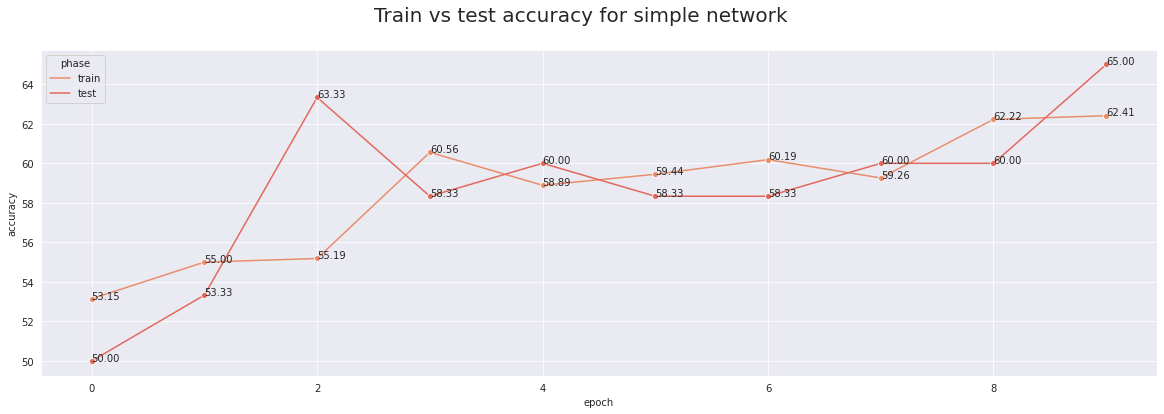

In [ ]:
# plot results accuracy
palette = sns.set_palette('flare')
sns.set_style("darkgrid")
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Train vs test accuracy for simple network', size=20)
sns.lineplot(data=results_simple, x='epoch', y='accuracy', hue='phase', marker = 'o', ax=ax1, color='black');

for _,item in results_simple.iterrows():
    ax1.text(item['epoch'],item['accuracy'],f'{item.accuracy:.2f}');


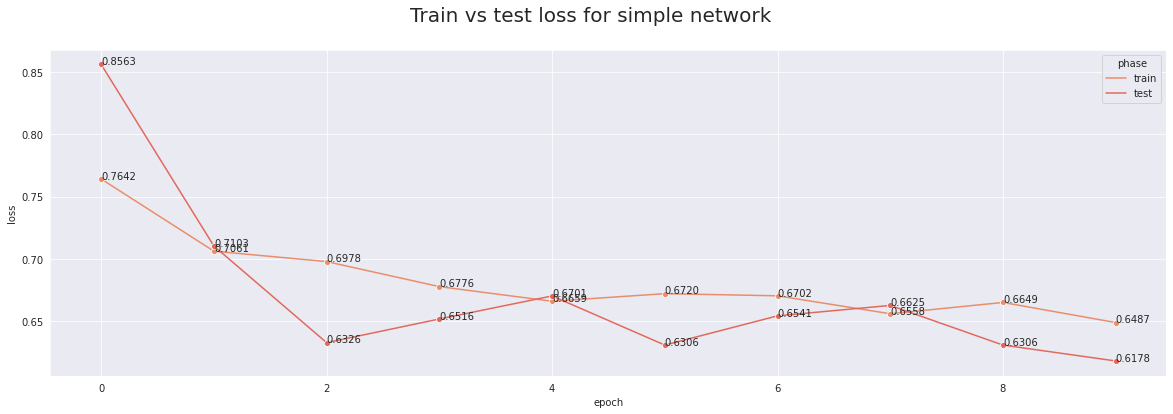

In [ ]:
# plot results loss
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Train vs test loss for simple network', size=20)
sns.lineplot(data=results_simple, x='epoch', y='loss', hue='phase', marker = 'o', ax=ax1, color='black');

for _,item in results_simple.iterrows():
    ax1.text(item['epoch'],item['loss'],f'{item.loss:.4f}');


In [ ]:
#from PIL import Image
#tiff = Image.open('/Users/juanpicciotti/BSE/2term/Spatial/project/data/0/image_1001.tif')
#tiff.show()
import rasterio
tiff = rasterio.open('/Users/juanpicciotti/BSE/2term/Spatial/project/data/0/image_1001.tif')
tiff.read()
#plt.imshow(tiff.read(1))


372

## Convolutional network case
### Parameter setup

In [ ]:
resize

(25, 25)

In [ ]:
# set parameters
channels = 3                            # channels for the images
img_size = resize[0]                     # image height=width
in_size = img_size*img_size*channels    # initial size fed to linear layers
out_size = 2                        # number of classes, also final output of the network
epochs = 10                             # number of epochs to run, kept to 10 to keep exercise computationally feasible
learning_rate = 0.00001                 # learning rate
gamma = 0.8                             # rate of learning rate decrease per epoch, if gamma=1 learning rate is fixed
momentum = 0.9                          # momentum
n_hidden = 128                          # number of hidden size (not the same as units)

### Define network architecture
<img src="cnn_network.png">

In [ ]:
 # setup CNN architecture
class convolutional1(nn.Module):
    def __init__(self, in_size, n_hidden, out_size):
        super(convolutional1, self).__init__()
        self.conv1 = nn.Conv2d(channels,16,kernel_size = 4) #(25-4+1)=22/2=14
        self.conv2 = nn.Conv2d(16,32,kernel_size = 3) #(14-3+1)=12
        self.conv3 = nn.Conv2d(32,64,kernel_size = 3) #(6,6)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(64*2*2, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 100)
        self.fc3 = nn.Linear(100, out_size)
        
        self.softmax = nn.LogSoftmax(dim=-1)

    def featurizer(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = nn.Flatten()(x)
        return x

    def classifier(self, x):

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = F.relu(x)
        
        x = self.softmax(x)
        return x

    def forward(self,x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x
 

### Instantiate and train/test the network model

In [ ]:
# instantiate model, setup optimizer, print network architecture summary
model_fnn = convolutional1(in_size, n_hidden, out_size) # convolutional
model_fnn.to(device)
optimizer = torch.optim.SGD(model_fnn.parameters(),lr=learning_rate, momentum=momentum)

summary(model_fnn, input_size = (channels,img_size,img_size), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 22, 22]             784
         MaxPool2d-2           [-1, 16, 11, 11]               0
            Conv2d-3             [-1, 32, 9, 9]           4,640
         MaxPool2d-4             [-1, 32, 4, 4]               0
            Conv2d-5             [-1, 64, 2, 2]          18,496
            Linear-6                  [-1, 128]          32,896
            Linear-7                  [-1, 100]          12,900
         Dropout2d-8                  [-1, 100]               0
            Linear-9                    [-1, 2]             202
       LogSoftmax-10                    [-1, 2]               0
Total params: 69,918
Trainable params: 69,918
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.27
Estimated Tot

In [ ]:
# run train and test tasks and store results
results = pd.DataFrame()

for epoch in range(0, epochs):
    temp = pd.DataFrame()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    print('Epoch = '+str(epoch)+' / Learning Rate = ',optimizer.param_groups[0]["lr"])
    
    train_accuracy, train_loss = train(model_fnn, optimizer, train_data_ldr)
    print('Train set: Average loss: {:.4f}, Accuracy:({:.0f}%)'.format(train_loss, train_accuracy))
    test_accuracy, test_loss = test(model_fnn, test_data_ldr)
    print('Test set: Average loss: {:.4f}, Accuracy:({:.0f}%)'.format(test_loss, test_accuracy))
    
    temp['nn'], temp['phase'], temp['epoch'], temp['accuracy'], temp['loss'] = zip(['cnn', 'train', epoch, train_accuracy, train_loss])
    results = results.append(temp)
    temp['nn'], temp['phase'], temp['epoch'],  temp['accuracy'], temp['loss'] = zip(['cnn', 'test', epoch, test_accuracy, test_loss])
    results = results.append(temp)
    scheduler.step()
    
results = results.reset_index()
results_cnn = results.drop('index', axis=1)

Epoch = 0 / Learning Rate =  1e-05


KeyboardInterrupt: ignored

### Results CNN

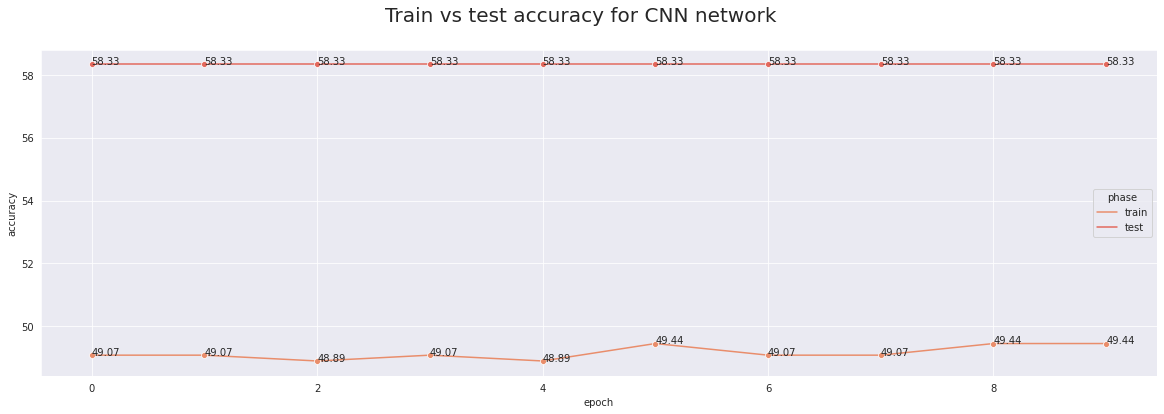

In [ ]:
# plot results accuracy
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Train vs test accuracy for CNN network', size=20)
sns.lineplot(data=results_cnn, x='epoch', y='accuracy', hue='phase', marker = 'o', ax=ax1, color='black');

for _,item in results_cnn.iterrows():
    ax1.text(item['epoch'],item['accuracy'],f'{item.accuracy:.2f}');

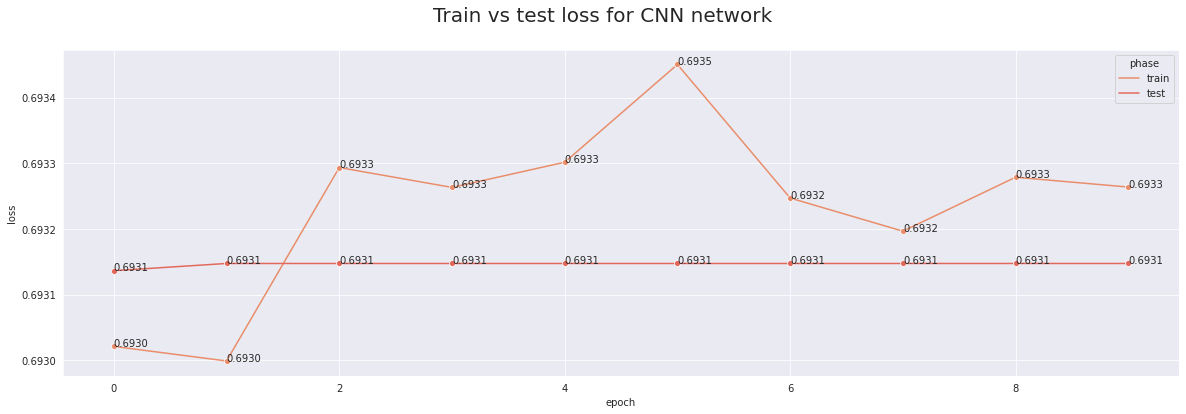

In [ ]:
# plot results loss
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Train vs test loss for CNN network', size=20)
sns.lineplot(data=results_cnn, x='epoch', y='loss', hue='phase', marker = 'o', ax=ax1, color='black');

for _,item in results_cnn.iterrows():
    ax1.text(item['epoch'],item['loss'],f'{item.loss:.4f}');

## Summary

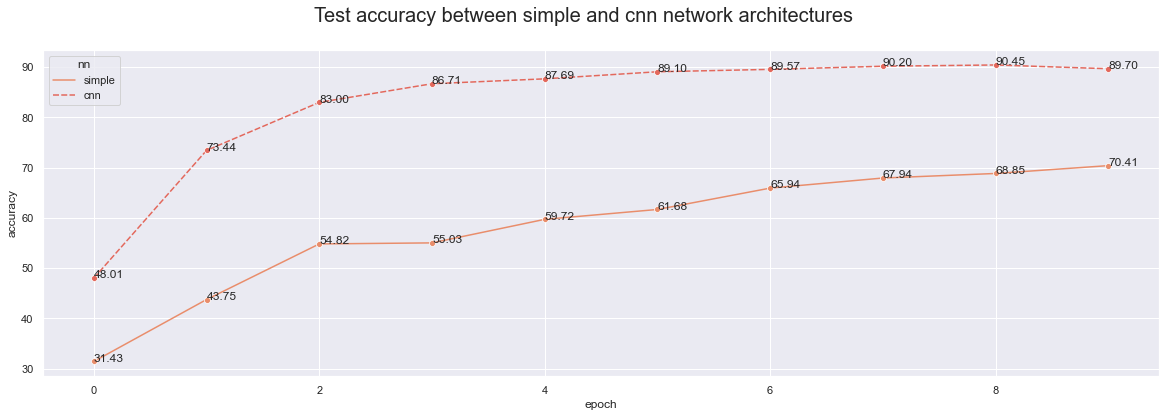

In [ ]:
# plot results compare networks accuracy
results_all = pd.concat([results_simple, results_cnn]).reset_index()
results_all = results_all[results_all['phase']=='test']

fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Test accuracy between simple and cnn network architectures', size=20)
sns.lineplot(data=results_all, x='epoch', y='accuracy', hue='nn', style='nn', marker = 'o', ax=ax1, color='black');

for _,item in results_all.groupby('nn'):
    for x,y,m in item[['epoch', 'accuracy','accuracy']].values:
        ax1.text(x,y,f'{m:.2f}')

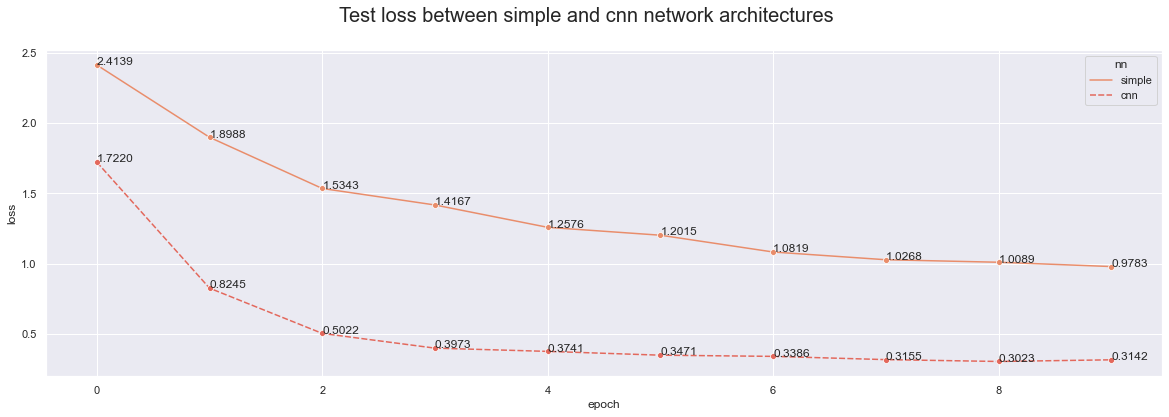

In [ ]:
# plot results compare networks loss
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Test loss between simple and cnn network architectures', size=20)
sns.lineplot(data=results_all, x='epoch', y='loss', hue='nn', style='nn', marker = 'o', ax=ax1, color='black');

for _,item in results_all.groupby('nn'):
    for x,y,m in item[['epoch', 'loss','loss']].values:
        ax1.text(x,y,f'{m:.4f}')